### [NewtonOptimizer](https://github.com/elavallee-github/elavallee-github.github.io/blob/71bfb3cc198a3c8c3c3033e952f95ab9cb5463c2/posts/newton-blog/logistic.py)

### Abstract

This blog posts aims to compare the Newton Optimizer to standard stochastic gradient descent. The post first aims to explore the correct implementation of the Newton Optimizer provided in the link to my source code above. After confirming that the optimizer is functioning properly, this blog compared Newton's ability to converge faster than stochastic gradient descent in some cases and to completely fail in its optimization in others this comparison was succesfully proven in the plots you will see later in this post. After that experimentation the computation units for Stochastic Gradient Descent and Newton's Optimizer were compared to see under what time step conditions would Newton be better than Stochastic Gradient Descent.

In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, NewtonOptimizer, GradientDescentOptimizer

### Produce data for Classification

Using code taken from Phil I am simply defining functions to produce classification data and then plot it for later.

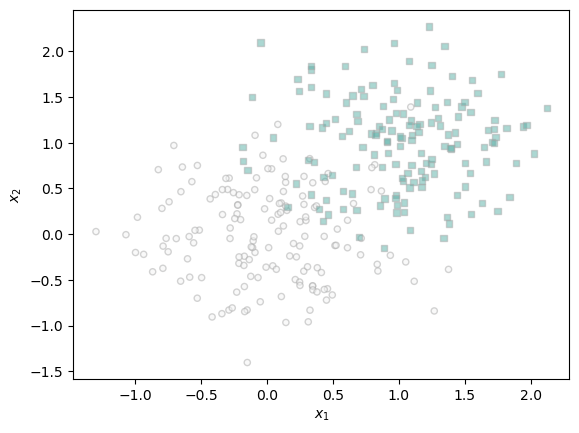

In [2]:
import torch
from matplotlib import pyplot as plt
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

def plot_classification_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(noise = 0.5)
plot_classification_data(X, y, ax)

Another function taken from Phil to plot our decision boundary on the trained data

In [3]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

### Optimizer Experimentation

Here is the main training loop that I developed. Inside a model is created and one of two optimizers, grad descent or Newton's can be chosen through the opt parameter. This training loop uses my implementation of Logistic Regression from one of the previous blog posts.

In [87]:
def train_LR(X, y, alpha, beta, max_iters, opt = 1):
    LR = LogisticRegression() 
    opt1 = NewtonOptimizer(LR)
    opt2 = GradientDescentOptimizer(LR)

    loss = 1
    loss_vec = []
    weights = []
    w_prev = None

    for _ in range(max_iters):
        # add other stuff to e.g. keep track of the loss over time. 
        loss = LR.loss(X,y)
        loss_vec.append(loss)
        if w_prev == None:
            w_prev = LR.w
        w = LR.w
        #print(w)
        weights.append(w)
        if(opt == 1): opt1.step(X, y, alpha = alpha)
        elif(opt == 2): opt2.step(X, y, alpha = alpha, beta = beta, w_prev = w_prev)
        w_prev = w

    return LR.w, loss_vec
    

The following code block trains three separate models, two with Newton's optimizer and one with grad descent. The first model has a learning rate such that it will converge faster than typical grad descent, the second model has a learning rate such that its optimization won't be succesful (it will actually increase very slightly as a sign it isn't working properly), and the third is just grad descent to act as a control.

Text(0, 0.5, 'Loss')

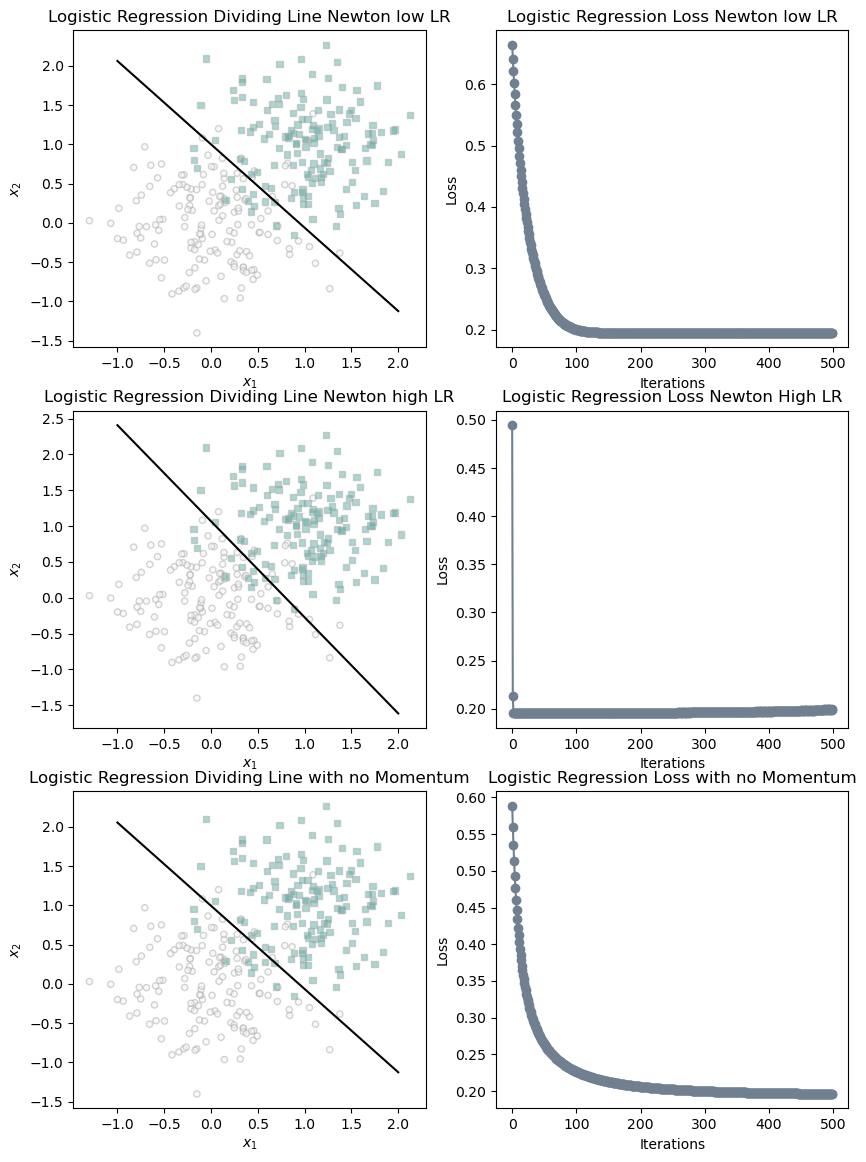

In [120]:
w_nm, loss_vec_nm = train_LR(X, y, alpha=10, beta = 0.0, max_iters=500, opt=1)
w_wm, loss_vec_wm = train_LR(X, y, alpha=601, beta = 0.0, max_iters=500, opt = 1)
w_gd, loss_vec_gd = train_LR(X, y, alpha=.5, beta = 0.0, max_iters=500, opt = 2)

# find an instance of the loss increasing before it becomes NaN



fig, ax = plt.subplots(3, 2, figsize=(10,14))
plot_classification_data(X, y, ax[0,0])
plot_classification_data(X, y, ax[1,0])
plot_classification_data(X, y, ax[2,0])
draw_line(w_nm, -1, 2, ax[0,0], color = "black")
draw_line(w_wm, -1, 2, ax[1,0], color = "black")
draw_line(w_gd, -1, 2, ax[2,0], color = "black")
ax[0,1].plot(loss_vec_nm, color = "slategrey")
ax[0,1].scatter(torch.arange(len(loss_vec_nm)), loss_vec_nm, color = "slategrey")
ax[1,1].plot(loss_vec_wm, color = "slategrey")
ax[1,1].scatter(torch.arange(len(loss_vec_wm)), loss_vec_wm, color = "slategrey")
ax[2,1].plot(loss_vec_gd, color = "slategrey")
ax[2,1].scatter(torch.arange(len(loss_vec_gd)), loss_vec_gd, color = "slategrey")
labs = plt.gca().set(xlabel = "Logistic Regression Iteration (Updates Only)", ylabel = "loss")
ax[0,0].set_title("Logistic Regression Dividing Line Newton low LR")
ax[1,0].set_title("Logistic Regression Dividing Line Newton high LR")
ax[2,0].set_title("Logistic Regression Dividing Line with no Momentum")

ax[0,1].set_title("Logistic Regression Loss Newton low LR")
ax[1,1].set_title("Logistic Regression Loss Newton High LR")
ax[2,1].set_title("Logistic Regression Loss with no Momentum")

ax[0,1].set_xlabel("Iterations")
ax[1,1].set_xlabel("Iterations")
ax[2,1].set_xlabel("Iterations")

ax[0,1].set_ylabel("Loss")
ax[1,1].set_ylabel("Loss")
ax[2,1].set_ylabel("Loss")

Looking at the above plots we can see that our first model using Newton's Optimizer, will reach convergence after almost 100 iterations, while the vanilla grad descent won't converge until around 350 or 400 iterations which is a pretty significant speed up for Newton's. The second model, while it drops to what seems like convergence instantly, after about 200 iterations we see the loss start to increase ever so slightly which is a sign that this model fails to converge. Answering an additional question from the blog post we can also confirm that our Newton's Optimizer is working correctly as the shape of our first plot very similarly matches the shape of our vanilla grad descent

### Operation Counting

Under the assumption set forth $t_{nm}$ must be of the form that $t_{nm}(3c + pc + k_1p^\gamma + k_2p^2)$ is less than $t_{gd}(3c)$. So $(3c + pc + k_1p^\gamma + k_2p^2)/t_{nm}$ must be less than $(3c)/t_{gd}$.

It doesn't seem like there will ever be a pay off for Newton's method once the dimensions become high enough. The number of time steps needed to reach an adequate solution at larger dimensions would just be impossible to reach given even for a dimensionality of five you would need your timestep $(8c + 25k_1 + 25K_2)/t_{nm}$ to be less than $(3c)/t_{gd}$. Depending on your k values and c values we're looking at anywhere from double the time to 20x on the conservative estimates of evaluations (20x for a world where $k_1$ and $k_2$ are both 1).

### Discussion

Through this blog post I learned yet another optimization strategy and some of the pitfalls of it. While Newton's Optimizer seems like it can allow for a nice speed up on smaller datasets with lower dimensions it seems that in datasets with higher dimensionality there is really no world where Newton's Optimizer would be used. However, it was really cool to implement another optimizer class and to get it to be faster than Gradient Descent which has been seen as the golden child for much of this class.